# Lưu ý : đặt train train.csv và test.csv lên drive như đừng dẫn 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil

source = "./drive/MyDrive/train.csv"
destination = "./train.csv"
shutil.copy(source, destination)

Mounted at /content/drive


'./train.csv'

In [2]:
!pip3 install tensorflow==2.15.0
!pip3 install keras==3.2.1
!pip3 install keras-nlp==0.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.4/508.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 107.0 MB/s eta 0:00:00
     ━━━━━━

# NOTE: tải đúng phiên bản các thư viện :
## TensorFlow: 2.15.0
## Keras: 3.2.1
## KerasNLP: 0.9.3

## Import các thư viện

In [3]:
from keras_nlp.models import DebertaV3Preprocessor
from keras_nlp.models import DebertaV3Classifier
import keras_nlp
import keras
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

#### Tham khảo: https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter#%F0%9F%8D%BD%EF%B8%8F-%7C-Preprocessing

## Các tham số

In [4]:
# TODO: đổi path file csv
data_path = "train.csv"
# Sử dụng model DeBERTa-V3-Extra-Small-English
model_preset = "deberta_v3_extra_small_en"
max_epochs = 10
batch_size = 32
shufle = 1000
lr = 0.000003

## Các hàm chính để xử lý model

### 1. Tiền xử lý dữ liệu

#### 1.1 Tiền xử lý label

 Label giá trị trị từ 1-6 (cột score) là dữ liệu categorical.
 Nhưng để làm bài này, label phải là dữ liệu ordinary
 Biến đổi label CATEGORICAL SANG ORDINARY bằng cách :

 Encode label thành một vector nhị phân có độ dài 6, bit i bằng 1 nghĩa là đã thỏa yêu cầu i
 Các giá trị trong vector CHO BIẾT XÁC SUẤT VỊ TRÍ i THỎA YÊU CẦU i.
 Từ đó có thể sử dụng CROSS-ENTROPY để sử dụng hàm lỗi so sánh sự tương đồng giữa 2 phân phối.

 Từ trên ta tạo tính ORDINARY như sau:

 Bài được chấm điểm 1 <= i <= 6 nghĩa là đã thỏa mãn yêu cầu i, VÀ CŨNG THỎA TẤT CẢ CÁC YÊU CẦU TRƯỚC ĐÓ (<= i),
 nên các bit trong vector nhãn sẽ = 1 ở các vị trí <= i, và 0 ở các vị trí còn lại.
 Cách làm này giúp có TÍNH SO SÁNH, vì một khi được điểm j >= i, thì các bit 1 của điểm i cũng = 1 ở trong j


In [5]:
def label_process(y):
    n = len(y)
    z = np.zeros((n, 6), "float32")
    for i in range(n):
        s = y[i]
        z[i, :s] = 1
    return z

#### 1.2 Tiền xử lý đầu vào

Lý do chúng ta cần thực hiện tiền xử lý đầu vào này là vì mô hình  DeBERTa không lấy văn bản thô làm đầu vào. Thay vào đó, chúng làm việc với cách biểu diễn kiểu số cho văn bản. DebertaV3Preprocessor xử lý các bước cần thiết để chuyển đổi văn bản thô thành các biểu diễn số này, bao gồm chuyển sang kiểu token (chia văn bản thành các từ hoặc từ phụ riêng lẻ) và mã hóa các token này dưới dạng số nguyên. Nó cũng đảm bảo rằng tất cả các chuỗi đầu vào đều có cùng độ dài 512, bằng cách đệm các chuỗi ngắn hơn hoặc cắt bớt các chuỗi dài hơn.

In [6]:
preprocessor = DebertaV3Preprocessor.from_preset(
    preset=model_preset,
    sequence_length=512,
)

def input_process(input, label):
    return (preprocessor(input), label)

100%|██████████| 424/424 [00:00<00:00, 1.09MB/s]
100%|██████████| 2.35M/2.35M [00:00<00:00, 6.07MB/s]


### 2. Tạo và cấu hình model

Load model đã được cấu hình và train sẵn, sau đó train để fine-tune model này phù hợp cho bài toán. </br>
Như đã nói trên sử đầù ra là một vector độ dài 6, mỗi vị trí cho biết xác suất thỏa yêu cầu i.</br>
Đầu ra của mạng sử dụng sigmoid cho ra giá trị 0->1, chuẩn hóa thành xác suất cho mỗi vị trí i.</br>
Sử dụng hàm Binary Cross-Entropy, vì ta tính xác suất mỗi vị trí (mỗi vị trí đúng (1) đến sai (0)),
sau đó keras.losses.BinaryCrossentropy tổng hợp Loss tại mỗi vị trí làm Loss chung
Sử dụng Adam optimizer kết hợp SGD và momentum

In [7]:
def create_DebertaV3_model(model_preset):
    debertaV3 = DebertaV3Classifier.from_preset(
        model_preset, preprocessor=None, num_classes=6
    )

    inputs = debertaV3.input
    outputs = debertaV3(inputs)

    prob_outputs = keras.layers.Activation("sigmoid")(outputs)
    model = keras.Model(inputs, prob_outputs)

    return model

### 3. Tạo dataset cho dữ liệu train và validation

Load dữ liệu từ file csv và tạo tf.data.Dataset cho dữ liệu train và dữ liệu validation.</br>
Dataset load dữ liệu theo lô (và cache để tiết kiệm bộ nhớ trong) và hoán vị dữ liệu sau mỗi vòng lặp cho THUẬT TOÁN SGD

In [8]:
def create_dataset():
    df = pd.read_csv(data_path)
    X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(
        df["full_text"], df["score"], test_size=0.2, stratify=df["score"]
    )
    X_train = X_train_df.tolist()
    X_val = X_val_df.tolist()
    y_train = label_process(y_train_df.tolist())
    y_val = label_process(y_val_df.tolist())
    train_ds = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .map(input_process)
        .cache()
        .shuffle(shufle, seed=0)
        .batch(batch_size)
    )
    opt = tf.data.Options()
    opt.experimental_deterministic = False
    train_ds = train_ds.with_options(opt)

    val_ds = (
        tf.data.Dataset.from_tensor_slices((X_val, y_val))
        .map(input_process)
        .cache()
        .batch(batch_size)
    )
    return train_ds, val_ds

## Huấn luyện model

In [9]:
train_ds, val_ds = create_dataset()
model = create_DebertaV3_model(model_preset)

model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss=keras.losses.BinaryCrossentropy(),
    jit_compile=True,
)
save_model = keras.callbacks.ModelCheckpoint(
    "model.weights.h5",  # HDF5
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)
# Train model
history = model.fit(
    x = train_ds,
    epochs=max_epochs,
    validation_data=val_ds,
    callbacks=[save_model],
)

100%|██████████| 539/539 [00:00<00:00, 210kB/s]
100%|██████████| 270M/270M [00:05<00:00, 52.9MB/s]


Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 1244s 2s/step - loss: 0.5250 - val_loss: 0.2515
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - loss: 0.2569 - val_loss: 0.2054
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - loss: 0.2097 - val_loss: 0.1849
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step - loss: 0.1877 - val_loss: 0.1756
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - loss: 0.1746 - val_loss: 0.1763
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - loss: 0.1666 - val_loss: 0.1697
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - loss: 0.1626 - val_loss: 0.1660
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - loss: 0.1562 - val_loss: 0.1675
Epoch 9/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - loss: 0.1544 - val_loss: 0.1639
Epoch 10/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - loss: 0.1499 - val_loss: 0.1621


## Thống kê lỗi và đánh giá

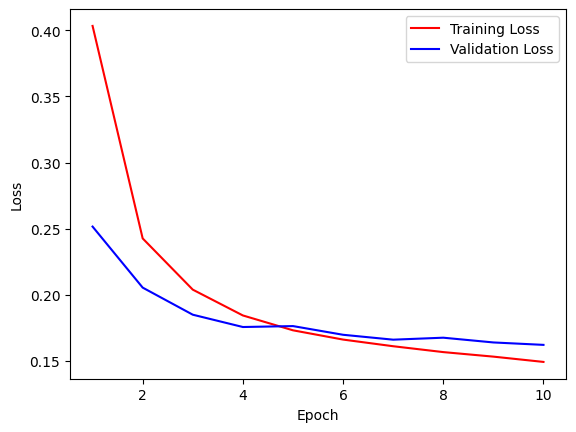

In [10]:
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

epoch_rows = range(1, len(training_loss) + 1)
plt.plot(epoch_rows, training_loss, "r-")
plt.plot(epoch_rows, validation_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig("Loss_plot.png")
plt.show()